# Pass Sonars

This notebook looks at plotting *Passing Sonars* based off [this article](https://totalfootballanalysis.com/data-analysis/data-analysis-france-south-korea-tactical-analysis-statistics) using StatsBomb [free data](https://statsbomb.com/academy/).

In [1]:
# Importing packages and data
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class
from matplotlib.patches import Arc, Rectangle
from matplotlib.projections.polar import RadialTick
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
from PIL import Image

import importing_sb as imsb
import draw_pitch as dp
import draw_pass_sonar as dps

plt.style.use('football')

data_dir = 'data/open-data/data/'

comp_data = imsb.open_data(data_dir + 'competitions.json')
lineup_data = imsb.open_data(data_dir + 'lineups/22921.json')
#match_data = open_data(data_dir + 'matches/22921.json')
data = imsb.open_data(data_dir + 'events/22921.json')
df = pd.json_normalize(data)

In [2]:
df.filter(like='location', axis=1).columns

Index(['location', 'pass.end_location', 'carry.end_location',
       'shot.end_location', 'goalkeeper.end_location'],
      dtype='object')

In [3]:
df.filter(like='tactics');

Getting player names for analysis and nicknames for plotting.

In [4]:
# Get player nicknames for plotting
nicknames = {}
for players in lineup_data[1]['lineup']:
    if players['player_nickname'] == None:
        nicknames[str(players['player_name'])] = str(players['player_name'])
    else:
        nicknames[str(players['player_name'])] = str(players['player_nickname'])

In [5]:
# Get player names
klist = []

for player in df['tactics.lineup'][0]:
    name = player['player']['name']
    klist.append(name)

Now assign players to a base location on the pitch. (It would be good to have a preset of locations for each formation)

In [6]:
# Assign player to base location
ylist = [0,25,25,25,25,50,50,75,75,100,100]
xlist = [40,10,30,50,70,30,50,30,50,30,50]

player_dict = {}
for x,y,z in zip(xlist, ylist, klist):
    entry = {z:[x,y]}
    player_dict.update(entry)

Define a function to, for a given player, sort their passes in bins based off the angle of the pass. Then find the average pass length and the fraction of passes in each bin.

In [7]:
# Function that returns a DataFrame with average pass length and fraction of passes in a given bin and the middle 
# of the corresponding bin for the specified player.
def Passer(player):
    local_df = df.copy()
    # Get passes by player
    local_df = local_df[(local_df["type.name"] == "Pass")&(local_df["player.name"] == str(player))]
    # Remove columns which are just full of NaN
    local_df = local_df.dropna(axis='columns', how='all')
    
    # Create DF with just pass angle and length
    df1 = local_df[['pass.angle','pass.length']].copy()
    bins = np.linspace(-np.pi,np.pi,12) # Define the bins for separating the angles into
    df1['binned'] = pd.cut(local_df['pass.angle'], bins, include_lowest=True, right=True)
    df1['Bin_Mids'] = df1['binned'].apply(lambda x: x.mid) # Find bin mids
    
    # Group passes by their bin and find the average pass length in those bins
    df2 = df1.groupby('Bin_Mids', as_index=False)['pass.length'].mean()
    df2 = df2.dropna(axis='index')
    
    # Find fraction of passes in each bin
    groups = df1.groupby('Bin_Mids', as_index=False)
    pass_frac = groups.size()/len(df1) # groupby().size() finds number of passes in each bin
    pass_frac = pass_frac[pass_frac != 0].values
    
    df2['pass_frac'] = pass_frac
    
    return df2

Finally plot the radars for the whole team. The fraction of total passes is the radius and the colour is the average length of the pass in that bin.

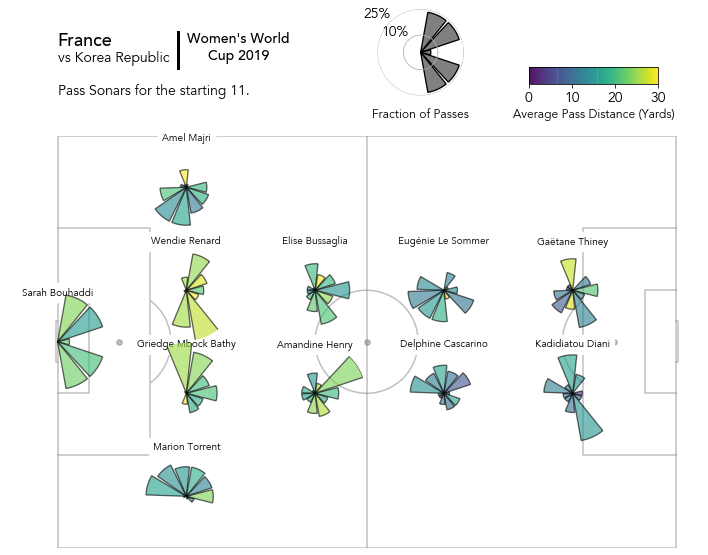

In [8]:
# Using number of passes for radius and length of pass for colour
import matplotlib

fig, ax = dp.draw_pitch('w', '0.5', 'h', 'f',alpha=0.5)

ax.set_ylim(0,80)
ax.set_xlim(-5,125)

# Define a function which creates an inset axes, i.e. the radar for a player
def plot_inset(width, axis_main, data, x, y):
    ax_sub = inset_axes(axis_main, width=width, height=width, loc='center',
                       bbox_to_anchor=(x,y),
                       bbox_transform=axis_main.transData,
                       borderpad=0.0, axes_class=get_projection_class("polar"))

    theta = data["Bin_Mids"]
    radii = data["pass_frac"]
    p_length = data['pass.length']
    bars = ax_sub.bar(theta, radii, width=0.5, bottom=0.0)

    ax_sub.set_ylim(0,0.25)
    ax_sub.set_xticklabels([])
    ax_sub.set_yticks([])
    ax_sub.yaxis.grid(False)
    ax_sub.xaxis.grid(False)
    ax_sub.spines['polar'].set_visible(False)
    ax_sub.set_theta_direction('clockwise')
    ax_sub.set_theta_zero_location('E')
    ax_sub.patch.set_alpha(0)  # Sets the axis backgrounds alpha
    
    # Colour the bars according to average pass length
    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=0,vmax=30)
    for p, bar in zip(p_length, bars):
        bar.set_facecolor(cmap(norm(p)))
        bar.set_alpha(0.6)
    
    return ax_sub

# Plotting the radar of each player
for player, loc in player_dict.items():
    plot_inset(1.4, ax, data = Passer(str(player)), x = loc[1], y = loc[0])
    ax.text(loc[1], loc[0]+9, nicknames[player], size=10, ha='center',backgroundcolor='w')

# Adding the radar legend
ax2 = fig.add_axes([0.5,0.93,0.15,0.15],projection='polar')
a = Passer(klist[0])
ax2.bar(a['Bin_Mids'], a['pass_frac'],width=0.5,color='0.5')
ax2.set_rlim(0,0.25)
ax2.set_rgrids([0.1,0.25],['10%','25%'],angle=135,ha='right',va='bottom')
ax2.set_thetagrids([],labels=[])
#ax2.grid(color='k')
ax2.spines['polar'].set_visible(False)
ax2.text(0.5,-0.15,"Fraction of Passes",transform=ax2.transAxes,ha='center',va='top',fontsize=12)

# Adding the colourbar legend
ax3 = fig.add_axes([0.7,0.95,0.15,0.03])
norm_range = plt.Normalize(vmin=0,vmax=30)
cbar = matplotlib.colorbar.ColorbarBase(ax3,cmap=plt.cm.get_cmap('viridis'), norm=norm_range, 
                                        orientation="horizontal",alpha=0.6)
cbar.set_ticks([0,10,20,30])
ax3.text(0.5,-1.4,"Average Pass Distance (Yards)",transform=ax3.transAxes,ha='center',va='top',fontsize=12)

# Other text annotations
axy = max(ax.get_ylim())-min(ax.get_ylim())
axx = min(ax.get_xlim())
team = ax.text(axx+5,axy+(axy*0.22),"France",fontsize=18,fontweight='semibold')
opp = ax.text(axx+5,axy+(axy*0.18),"vs Korea Republic",fontsize=14)
plt.draw() # Must include otherwise get_window_extent doesn't work as the text hasn't been drawn

#Finding the max x and y of the bbox for the team/opposition
x, y = zip(team.get_window_extent().max, opp.get_window_extent().max)
x = max(x)
y = max(y)
xa, ya = ax.transAxes.inverted().transform([x,y])
xd, yd = ax.transData.inverted().transform([x,y]) # Convert from display to data units

ax.text(xd+(0.16*xd),yd,"Women's World\nCup 2019",fontsize=14,va='top',fontweight='semibold',multialignment='center')
ax.axvline(xd+(0.08*xd),0.93*ya,ya,clip_on=False,c='k')

ax.text(axx+5,axy+(axy*0.10),"Pass Sonars for the starting 11.",fontsize=14)

ax.set_aspect('equal')
plt.show()

## Messi Passing Sonar in each pitch zone

In [9]:
# comp_id = 11 is La Liga, season_id = 4 is 18/19
match_data = sorted(imsb.open_data(data_dir + 'matches/11/4.json'), key = lambda x: x['match_date'])
mid = match_data[0]['match_id']
lineup_data = imsb.open_data(data_dir + 'lineups/{}.json'.format(mid))
data = imsb.open_data(data_dir + 'events/{}.json'.format(mid))
df = pd.json_normalize(data)

In [10]:
def get_nicknames(lineup_data,team=0):
    nicknames = {}
    for players in lineup_data[team]['lineup']:
        if players['player_nickname'] == None:
            nicknames[str(players['player_name'])] = str(players['player_name'])
        else:
            nicknames[str(players['player_name'])] = str(players['player_nickname'])
    return nicknames

In [11]:
nicknames = get_nicknames(lineup_data)

In [12]:
def get_starting11(df,team=0):
    klist = []
    for player in df['tactics.lineup'][team]:
        name = player['player']['name']
        klist.append(name)
    return klist

In [13]:
klist = get_starting11(df)

In [14]:
player_dict = {}
for x,y,z in zip(xlist, ylist, klist):
    entry = {z:[x,y]}
    player_dict.update(entry)

In [15]:
xgrid = np.linspace(0,120,7)
ygrid = np.linspace(0,80,4)

In [16]:
df_pass = df.copy()
df_pass = df_pass[(df_pass["type.name"] == "Pass")&(df["player.name"] == str(klist[10]))]
df_pass = df_pass.dropna(axis='columns', how='all')

In [17]:
df1 = df_pass[['pass.length','pass.angle']].copy()
angle_bins = np.linspace(-np.pi,np.pi+0.001,12) #np.pi is too precise for the angle measurements
df1['angle_mid'] = pd.cut(df1['pass.angle'],angle_bins,include_lowest=True).apply(lambda x: x.mid)
df1['x'] = df_pass['location'].apply(lambda x: x[0])
df1['y'] = df_pass['location'].apply(lambda x: 80-x[1])

In [18]:
df1['x_zone'] = pd.cut(df1['x'], xgrid, include_lowest = True).apply(lambda x: x.mid)
df1['y_zone'] = pd.cut(df1['y'], ygrid, include_lowest = True).apply(lambda x: x.mid)

In [19]:
# Number of passes in each bin
counts = df1.groupby(['x_zone','y_zone']).size()
counts.rename('counts',inplace=True)

x_zone    y_zone 
9.9995    13.3330     0
          40.0000     0
          66.6665     0
30.0000   13.3330     0
          40.0000     0
          66.6665     0
50.0000   13.3330     4
          40.0000     3
          66.6665     0
70.0000   13.3330    20
          40.0000     9
          66.6665     4
90.0000   13.3330    29
          40.0000    12
          66.6665     2
110.0000  13.3330     7
          40.0000     2
          66.6665     0
Name: counts, dtype: int64

In [20]:
df1 = df1.merge(counts,right_index=True,left_on=['x_zone','y_zone'])

In [21]:
df1.head()

,pass.length,pass.angle,angle_mid,x,y,x_zone,y_zone,counts
59,24.596748,-0.463648,-0.5705,77.0,2.0,70.0,13.333,20
111,9.055386,-1.681454,-1.7135,78.0,3.0,70.0,13.333,20
121,43.174065,-1.804540,-1.7135,72.0,6.0,70.0,13.333,20
815,14.866069,-0.832981,-0.5705,79.0,3.0,70.0,13.333,20
908,8.000000,-1.570796,-1.7135,80.0,13.0,70.0,13.333,20


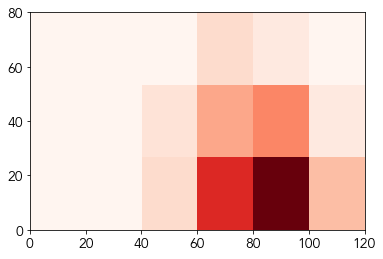

In [22]:
df1_img = df1.groupby(['x_zone','y_zone']).size().reset_index().pivot('y_zone','x_zone',0)
#plt.imshow(df1_img[::-1],extent=[0,120,0,80], aspect='auto', cmap='Reds')
plt.imshow(df1_img[::-1]/counts.sum(),extent=[0,120,0,80], aspect='auto', cmap='Reds')

In [23]:
df2 = df1.groupby(['x_zone','y_zone','angle_mid'],as_index=False)['pass.length'].mean().dropna()

In [24]:
# Calculate the fraction of passes in that zone that are in each angle bin
df2['pass_frac'] = (df1.groupby(['x_zone','y_zone','angle_mid']).size()/
                    df1.groupby(['x_zone','y_zone','angle_mid'])['counts'].mean()).rename('pass_frac').dropna().values

In [25]:
df2.head()

,x_zone,y_zone,angle_mid,pass.length,pass_frac
66,50.0,13.333,-2.8565,29.832869,0.250000
69,50.0,13.333,-1.1420,65.306970,0.250000
70,50.0,13.333,-0.5705,39.450950,0.500000
78,50.0,40.000,-2.2845,7.810250,0.333333
81,50.0,40.000,-0.5705,18.835605,0.666667


In [26]:
def change_range(value,old_range,new_range):
    return ((value - old_range[0])/(old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]

In [27]:
# Define a function which creates an inset axes, i.e. the radar for a player
def plot_inset(width, axis_main, data, x, y, ymax=0.3, alpha=0.6, c_map='viridis', zero_loc='E'):
    if len(data) == 0:
        return
        
    ax_sub = inset_axes(axis_main, width=width, height=width, loc='center',
                       bbox_to_anchor=(x, y),bbox_transform=axis_main.transData,
                       borderpad=0.0, axes_class=get_projection_class("polar"))

    theta = data["angle_mid"]
    radii = data["pass_frac"]
    p_length = data['pass.length']
    bars = ax_sub.bar(theta, radii, width=0.5, bottom=0.0)

    ax_sub.set_ylim(0,ymax)
    ax_sub.set_xticklabels([])
    ax_sub.set_yticklabels([])
    ax_sub.set_yticks([0.1,0.2,0.3])
    ax_sub.tick_params(which='major',grid_color='0.9',grid_alpha=alpha)
    #ax_sub.yaxis.set_minor_locator(AutoMinorLocator(2))
    #ax_sub.tick_params(which='minor',grid_color='0.8',grid_linestyle='--')
    ax_sub.yaxis.grid(True, which='major')
    ax_sub.xaxis.grid(False)
    ax_sub.spines['polar'].set_visible(True)
    ax_sub.set_theta_direction('clockwise')
    ax_sub.set_theta_zero_location(zero_loc)
    ax_sub.set_facecolor('0.6')
    ax_sub.patch.set_alpha(alpha)  # Sets the axis backgrounds alpha
    
    # Colour the bars according to average pass length
    cmap = plt.cm.get_cmap(c_map)
    norm = plt.Normalize(vmin=0,vmax=30)
    for p, bar in zip(p_length, bars):
        bar.set_facecolor(cmap(norm(p)))
        bar.set_alpha(alpha)
    
    return ax_sub

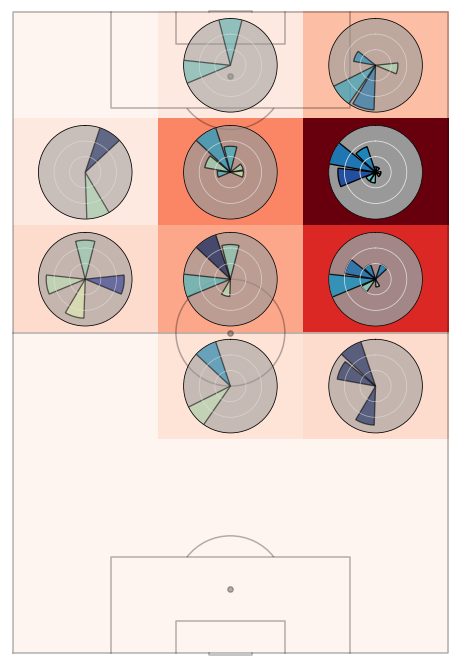

In [28]:
fig,ax = dp.draw_pitch('w','k','v','f',alpha=0.3)

ax.imshow(df1_img[::-1].T[::-1],extent=[0,80,0,120], aspect='auto', cmap='Reds')

for xzone in df2['x_zone'].unique():
    for yzone in df2['y_zone'].unique():
        alpha = change_range(counts.loc[xzone,yzone],(0,counts.max()),(0.5,1))
        df_zone = df2[(df2['x_zone'] == xzone)&(df2['y_zone'] == yzone)]
        plot_inset(1.3,ax,df_zone,80-yzone,xzone,alpha=alpha, c_map='YlGnBu',zero_loc='N')

plt.show()

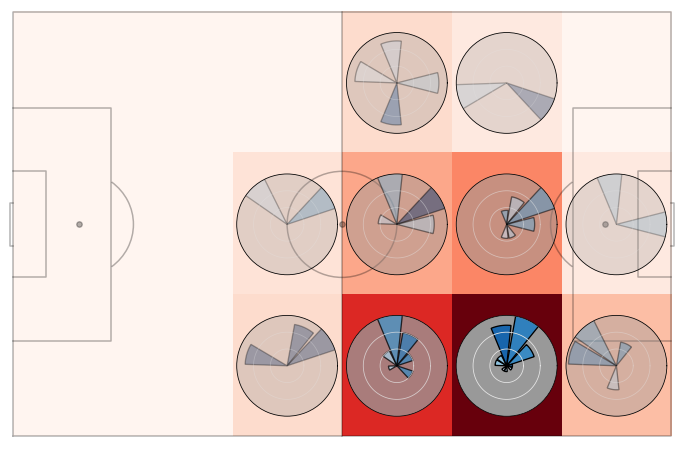

In [29]:
fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)

ax.imshow(df1_img[::-1],extent=[0,120,0,80], aspect='auto', cmap='Reds')

for xzone in df2['x_zone'].unique():
    for yzone in df2['y_zone'].unique():
        alpha = change_range(counts.loc[xzone,yzone],(0,counts.max()),(0.2,1))
        df_zone = df2[(df2['x_zone'] == xzone)&(df2['y_zone'] == yzone)]
        plot_inset(1.4,ax,df_zone,xzone,yzone,alpha=alpha, c_map='Blues')

plt.show()

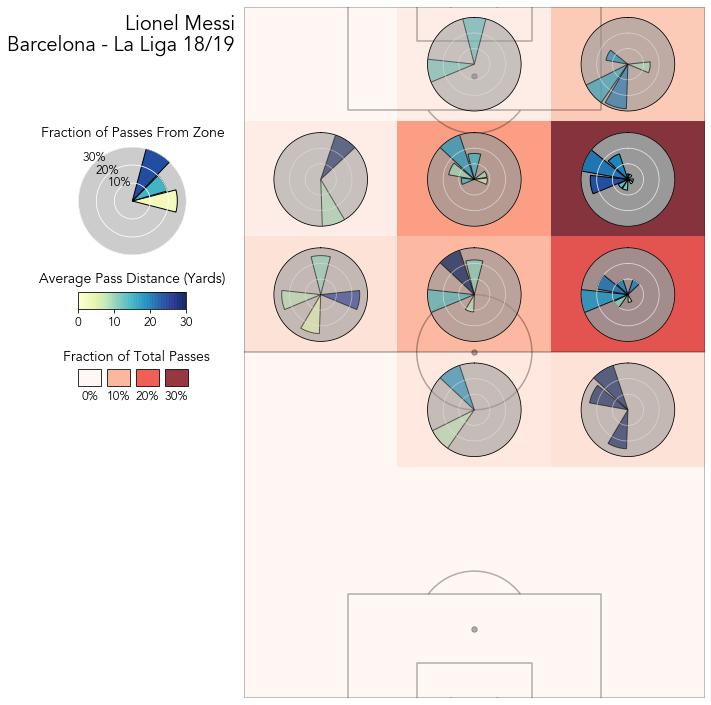

In [30]:
mpl.rcParams['patch.linewidth'] = 1

zone_cmap = plt.cm.get_cmap('Reds')
bar_cmap = plt.cm.get_cmap('YlGnBu')
zone_vmax = counts.max()/counts.sum()
zone_norm_range = plt.Normalize(vmin=0,vmax=zone_vmax)

fig = plt.figure(figsize=(10,12))
ax = fig.add_axes([0.2,0.1,0.8,0.8])

_,ax = dp.draw_pitch('w','k','v','f',figax=(fig,ax),alpha=0.3)

ax.imshow(df1_img[::-1].T[::-1],extent=[0,80,0,120], aspect='auto', cmap=zone_cmap,alpha=0.8)

for xzone in df2['x_zone'].unique():
    for yzone in df2['y_zone'].unique():
        alpha = change_range(counts.loc[xzone,yzone],(0,counts.max()),(0.5,1))
        df_zone = df2[(df2['x_zone'] == xzone)&(df2['y_zone'] == yzone)]
        plot_inset(1.3, ax, df_zone, 80-yzone, xzone, alpha=alpha, c_map=bar_cmap, zero_loc='N')

ax.set_aspect('equal')
        
# Adding the radar legend
ax2 = fig.add_axes([0.05,0.6,0.15,0.15], projection='polar')
bars = ax2.bar([0,0.53,0.53*2], [0.25,0.2,0.3], width=0.5, color=bar_cmap(0.8))
for val,bar in zip([0.1,0.5,0.8],bars):
    bar.set_facecolor(bar_cmap(val))
ax2.set_rlim(0,0.25)
ax2.set_rgrids([0.1,0.2,0.3],['10%','20%','30%'],angle=135,ha='center',va='bottom')
ax2.set_thetagrids([],labels=[])
ax2.tick_params(labelsize=12)
ax2.grid(color='w')
ax2.spines['polar'].set_visible(False)
ax2.set_facecolor('0.8')
ax2.text(0.5,1.2,"Fraction of Passes From Zone",transform=ax2.transAxes,ha='center',va='top',fontsize=14)
    
# Adding the sonar colourbar legend
ax3 = fig.add_axes([0.05,0.55,0.15,0.02])
norm_range = plt.Normalize(vmin=0,vmax=30)
cbar = matplotlib.colorbar.ColorbarBase(ax3,cmap=plt.cm.get_cmap('YlGnBu'), norm=norm_range, 
                                        orientation="horizontal",alpha=0.6)
cbar.set_ticks([0,10,20,30])
ax3.tick_params(labelsize=12)
ax3.text(0.5,1.3,"Average Pass Distance (Yards)",transform=ax3.transAxes,ha='center',va='bottom',fontsize=14)

# Adding the zone colourbar legend
ax4 = fig.add_axes([0.05,0.46,0.16,0.02])
zone_vmax = counts.max()/counts.sum()
cmap = plt.cm.get_cmap('Reds')
for pos,frac in zip([0,0.25,0.5,0.75],np.arange(0,round(zone_vmax,1)+0.1,0.1)):
    rect = Rectangle((pos,0.05),0.2,0.97,transform=ax4.transAxes, ec='k', fc=zone_cmap(zone_norm_range(frac)),alpha=0.8)
    ax4.add_patch(rect)
    ax4.text(pos+0.1,-0.15,"{:.0f}%".format(frac*100),transform=ax4.transAxes,ha='center',va='top',fontsize=12)
ax4.set_ylim([0,1])
ax4.axis('off')
ax4.text(0.5,1.3,"Fraction of Total Passes",transform=ax4.transAxes,ha='center',va='bottom',fontsize=14)
    
# Info text
ax.text(-0.02,0.99,"{}".format(nicknames[klist[10]]),transform=ax.transAxes,fontsize=20,ha='right',va='top')
ax.text(-0.02,0.96,"{} - {}".format('Barcelona',"La Liga 18/19"),transform=ax.transAxes,fontsize=20,ha='right',va='top')
#ax.text(-0.02,0.96,"vs ".format('Barcelona',"La Liga 18/19"),transform=ax.transAxes,fontsize=20,ha='right',va='top')
    
plt.show()
#fig.savefig('example_plots/pass_sonar.png',dpi=100,bbox_inches = 'tight',pad_inches=0.1)

In [35]:
pass_sonar_zones(data, 'Barcelona', sonar='team', legend=True, badge=True);

In [30]:
df_test = df_pass[['type.name','team.name','location','pass.end_location','player.name','pass.recipient.name',
         'pass.length','pass.angle','pass.type.name','pass.outcome.name']].copy()

In [31]:
df_test['x'] = df_test['location'].apply(lambda x: x[0])
df_test['y'] = df_test['location'].apply(lambda x: 80-x[1])
df_test['end_x'] = df_test['pass.end_location'].apply(lambda x: x[0])
df_test['end_y'] = df_test['pass.end_location'].apply(lambda x: 80-x[1])
df_test.drop(['location','pass.end_location'],axis=1,inplace=True)
df_test = df_test[df_test['pass.type.name'].isnull()].copy()
df_test.loc[:,'pass.type.name'].fillna('Open Play', inplace=True)
df_test.loc[:,'pass.outcome.name'].fillna('Complete', inplace=True)
df_test.rename(columns={'type.name': 'type', 'team.name': 'team', 'player.name': 'player', 'pass.length': 'length', 'pass.angle': 'angle',
                       'pass.type.name': 'pass_type', 'pass.outcome.name': 'outcome'}, inplace=True)

In [32]:
angle_bins = np.linspace(-np.pi,np.pi+0.001,12)
df_test['angle_mid'] = pd.cut(df_test['angle'], angle_bins, include_lowest=True).apply(lambda x: x.mid)
df_test.replace({'Complete': 1}, inplace=True)
df_test.replace({i: 0 for i in df_test['outcome'].unique() if i is not 1}, inplace=True)

In [33]:
df_test_grouped = df_test.groupby('angle_mid',as_index=False)['length'].mean().dropna()
df_test_grouped['fraction'] = (df_test.groupby('angle_mid').size()/len(df_test)).values
df_test_grouped['success'] = (df_test.groupby('angle_mid')['outcome'].sum()/df_test.groupby('angle_mid').size()).values

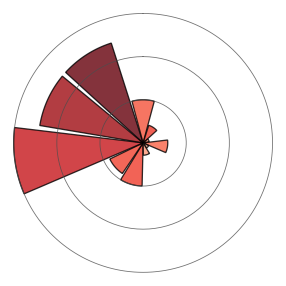

In [34]:
dps.pass_sonar(df_test,bar_len_var='fraction',bar_cmap_var='length',bar_cmap='Reds')

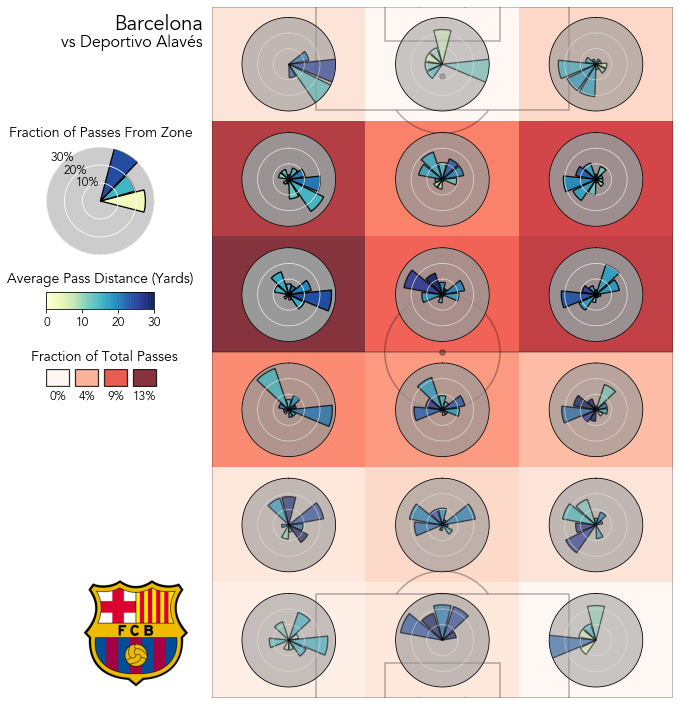

(<Figure size 720x864 with 23 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fddeedb8f10>)

In [43]:
dps.pass_sonar_zones(data_dir+'events/',15946, name='Barcelona', sonar='team', legend=True, badge=True)